In [1]:
import os
import pandas as pd
import numpy as np
import torch
import dill as pickle

import statistics
import math
import plotly
import plotly.graph_objs as go
import plotly.express as px

from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

import bamt.Networks as Nets
import bamt.Nodes as Nodes
import bamt.Preprocessors as pp
from pgmpy.estimators import K2Score

from tedeous.solver import grid_format_prepare

from IPython.core.display import SVG
from IPython import display
import warnings
warnings.filterwarnings('ignore')

C:\Users\user\anaconda3\envs\article\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<h2><center>Уравнение Лотки — Вольтерры (модель Хищник-Жертва)</center></h2>

\begin{equation*}
 \begin{cases}
  \Large\frac{\partial u}{\partial t} = \normalsize(\alpha - \beta v)u, 
   \\
   \Large\frac{\partial v}{\partial t} = \normalsize (-\gamma + \delta u)v.
 \end{cases}
\end{equation*}

$u(t)$ - функция, показывающая кол-во жертв;  <br> 
$v(t)$ - функция, показывающая кол-во хищников;  <br> 

$\alpha$ - коэффициент рождаемости жертв;  <br> 
$\beta$ - коэффициент убийства жертв;  <br> 
$\gamma $ - коэффициент убыли хищников;  <br> 
$\delta$ - коэффициент способности к воспроизводству.  <br> 

Источник<a id='Source'></a>: https://github.com/stan-dev/example-models/blob/master/knitr/lotka-volterra/hudson-bay-lynx-hare.csv

Данные: Ежегодная информация о популяциях рысей и зайцев с 1900 по 1920 год (21 строка)

In [2]:
source = pd.read_csv('hudson-bay-lynx-hare.csv', sep = ', ', engine = 'python').values
t = source[:, 0]
x = source[:, 1] # Lynx/Hunters
y = source[:, 2] # Hare/Prey
source_data = [y, x]

In [3]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=t, y=y, name=f'Исходные данные - u (Заяц)', line=dict(color='firebrick', width=2)))
fig.add_trace(go.Scatter(x=t, y=x, name=f'Исходные данные - v (Рысь)', line=dict(color='black', width=2)))
fig.update_layout(xaxis_title="Time, t [Years]", yaxis_title="Population")
fig.show()

Применение алгоритма многокритериальной эволюционной оптимизации позволяет получить Парето-оптимальное множество уравнений, которые не доминируют друг друга. При многократном запуске алгоритма [на одних и тех же данных](#Source) происходит сбор полученных уравнений и их коэффициентов. Структура таблицы представлена на рисунке, приведенном ниже:

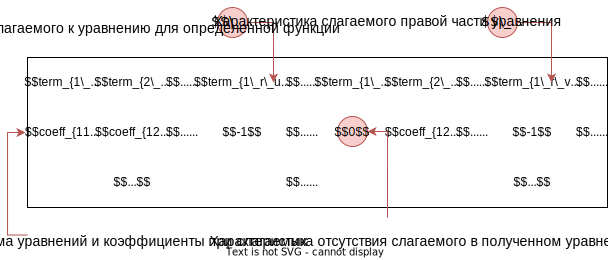

In [4]:
SVG(filename='info_rus.svg')

Столбцами в таблице являются слагаемые, которые получаются в процессе поиска дифференциальных уравнений в частных производных. Каждая запись/строка содержит коэффициенты для каждого слагаемого.

Данная структура необходима для построения совместного распределения с целью определения, какие слагаемые чаще всего встречаются вместе. На основе этих данных будет построена байесовская сеть, которая позволит анализировать взаимосвязи и зависимости между слагаемыми в системе.

### 1. Предварительная обработка

Предобработка включает в себя удаление нулевых столбцов/строк, анализ частоты появления определенных слагаемых и оценку разнообразия полученных уравнений.

In [5]:
path = 'numerical_results/'
df = pd.read_csv(f'{path}output_main_hunter_prey_lynx_hare.csv', index_col = 'Unnamed: 0', sep='\t', encoding='utf-8')
df.shape

(211, 21)

In [6]:
df.head()

C_u  v{power: 1.0} * u{power: 1.0}_u  u{power: 1.0}_u  \
0   0.065667                        -0.027988         0.546189   
1  17.890508                         0.000000         0.000000   
2   0.065667                        -0.027988         0.546189   
3  17.890508                         0.000000         0.000000   
4   0.065667                        -0.027988         0.546189   

   v{power: 1.0}_u  v{power: 1.0} * dv/dx1{power: 1.0}_u  \
0         0.000000                              0.000000   
1        -0.906833                             -0.011958   
2         0.000000                              0.000000   
3        -0.906833                             -0.011958   
4         0.000000                              0.000000   

   u{power: 1.0} * du/dx1{power: 1.0}_u  dv/dx1{power: 1.0}_u  \
0                                   0.0                   0.0   
1                                   0.0                   0.0   
2                                   0.0                   0.0   
3                                   0.0                   0.0   
4                                   0.0                   0.0   

   du/dx1{power: 1.0} * dv/dx1{power: 1.0}_u  \
0                                        0.0   
1                                        0.0   
2                                        0.0   
3                                        0.0   
4                                        0.0   

   du/dx1{power: 1.0} * v{power: 1.0}_u  du/dx1{power: 1.0}_r_u  ...  \
0                                   0.0                    -1.0  ...   
1                                   0.0                    -1.0  ...   
2                                   0.0                    -1.0  ...   
3                                   0.0                    -1.0  ...   
4                                   0.0                    -1.0  ...   

   v{power: 1.0}_v  v{power: 1.0} * u{power: 1.0}_v  u{power: 1.0}_v  \
0        -0.837908                         0.026033              0.0   
1        -0.837908                         0.026033              0.0   
2        -0.837908                         0.026033              0.0   
3        -0.837908                         0.026033              0.0   
4        -0.837908                         0.026033              0.0   

   dv/dx1{power: 1.0} * v{power: 1.0}_v  dv/dx1{power: 1.0} * u{power: 1.0}_v  \
0                                   0.0                                   0.0   
1                                   0.0                                   0.0   
2                                   0.0                                   0.0   
3                                   0.0                                   0.0   
4                                   0.0                                   0.0   

   du/dx1{power: 1.0}_v  dv/dx1{power: 1.0} * du/dx1{power: 1.0}_v  \
0                   0.0                                        0.0   
1                   0.0                                        0.0   
2                   0.0                                        0.0   
3                   0.0                                        0.0   
4                   0.0                                        0.0   

   du/dx1{power: 1.0} * u{power: 1.0}_v  dv/dx1{power: 1.0}_r_v  \
0                                   0.0                    -1.0   
1                                   0.0                    -1.0   
2                                   0.0                    -1.0   
3                                   0.0                    -1.0   
4                                   0.0                    -1.0   

   dv/dx1{power: 1.0} * u{power: 1.0}_r_v  
0                                     0.0  
1                                     0.0  
2                                     0.0  
3                                     0.0  
4                                     0.0  

[5 rows x 21 columns]

In [7]:
for col in df.columns:
    df[col] = df[col].round(decimals = 10)

In [8]:
# Deleting rows if all coefficients on the left side are zero and the coefficient on the right side is -1 (based on the sum of row elements).
df = df.loc[(df.sum(axis=1) != -2), (df.sum(axis=0) != 0)] # for system
# Removing zero columns
df = df.loc[:, (df != 0).any(axis=0)]
# Count of nonzero values in columns
(df != 0).sum(axis = 0)

C_u                                          211
v{power: 1.0} * u{power: 1.0}_u              164
u{power: 1.0}_u                              162
v{power: 1.0}_u                               40
v{power: 1.0} * dv/dx1{power: 1.0}_u           7
u{power: 1.0} * du/dx1{power: 1.0}_u          29
dv/dx1{power: 1.0}_u                           9
du/dx1{power: 1.0} * dv/dx1{power: 1.0}_u      6
du/dx1{power: 1.0} * v{power: 1.0}_u           5
du/dx1{power: 1.0}_r_u                       211
C_v                                          211
v{power: 1.0}_v                              159
v{power: 1.0} * u{power: 1.0}_v              155
u{power: 1.0}_v                               46
dv/dx1{power: 1.0} * v{power: 1.0}_v          37
dv/dx1{power: 1.0} * u{power: 1.0}_v           8
du/dx1{power: 1.0}_v                           7
dv/dx1{power: 1.0} * du/dx1{power: 1.0}_v      8
du/dx1{power: 1.0} * u{power: 1.0}_v           2
dv/dx1{power: 1.0}_r_v                       210
dv/dx1{power: 1.0} *

In [9]:
df_initial = df.copy() # The initial data is used for learning the Bayesian network

In [10]:
df.shape

(211, 21)

In [11]:
for col in df.columns:
    if '_r' in col:
        df = df.astype({col: "int64"})
        df = df.astype({col: "str"}) # Discrete values are wrapped as strings to ensure proper functioning during learning

In [12]:
df.head()

C_u  v{power: 1.0} * u{power: 1.0}_u  u{power: 1.0}_u  \
0   0.065667                        -0.027988         0.546189   
1  17.890508                         0.000000         0.000000   
2   0.065667                        -0.027988         0.546189   
3  17.890508                         0.000000         0.000000   
4   0.065667                        -0.027988         0.546189   

   v{power: 1.0}_u  v{power: 1.0} * dv/dx1{power: 1.0}_u  \
0         0.000000                              0.000000   
1        -0.906833                             -0.011958   
2         0.000000                              0.000000   
3        -0.906833                             -0.011958   
4         0.000000                              0.000000   

   u{power: 1.0} * du/dx1{power: 1.0}_u  dv/dx1{power: 1.0}_u  \
0                                   0.0                   0.0   
1                                   0.0                   0.0   
2                                   0.0                   0.0   
3                                   0.0                   0.0   
4                                   0.0                   0.0   

   du/dx1{power: 1.0} * dv/dx1{power: 1.0}_u  \
0                                        0.0   
1                                        0.0   
2                                        0.0   
3                                        0.0   
4                                        0.0   

   du/dx1{power: 1.0} * v{power: 1.0}_u du/dx1{power: 1.0}_r_u  ...  \
0                                   0.0                     -1  ...   
1                                   0.0                     -1  ...   
2                                   0.0                     -1  ...   
3                                   0.0                     -1  ...   
4                                   0.0                     -1  ...   

   v{power: 1.0}_v  v{power: 1.0} * u{power: 1.0}_v  u{power: 1.0}_v  \
0        -0.837908                         0.026033              0.0   
1        -0.837908                         0.026033              0.0   
2        -0.837908                         0.026033              0.0   
3        -0.837908                         0.026033              0.0   
4        -0.837908                         0.026033              0.0   

   dv/dx1{power: 1.0} * v{power: 1.0}_v  dv/dx1{power: 1.0} * u{power: 1.0}_v  \
0                                   0.0                                   0.0   
1                                   0.0                                   0.0   
2                                   0.0                                   0.0   
3                                   0.0                                   0.0   
4                                   0.0                                   0.0   

   du/dx1{power: 1.0}_v  dv/dx1{power: 1.0} * du/dx1{power: 1.0}_v  \
0                   0.0                                        0.0   
1                   0.0                                        0.0   
2                   0.0                                        0.0   
3                   0.0                                        0.0   
4                   0.0                                        0.0   

   du/dx1{power: 1.0} * u{power: 1.0}_v  dv/dx1{power: 1.0}_r_v  \
0                                   0.0                      -1   
1                                   0.0                      -1   
2                                   0.0                      -1   
3                                   0.0                      -1   
4                                   0.0                      -1   

  dv/dx1{power: 1.0} * u{power: 1.0}_r_v  
0                                      0  
1                                      0  
2                                      0  
3                                      0  
4                                      0  

[5 rows x 21 columns]

In [13]:
df.groupby(df.columns.tolist(),as_index=False).size()  # The number of diverse obtained systems

C_u  v{power: 1.0} * u{power: 1.0}_u  u{power: 1.0}_u  \
0   -0.719965                         0.000000         0.008748   
1   -0.388341                         0.000000         0.000000   
2   -0.388341                         0.000000         0.000000   
3   -0.388341                         0.000000         0.000000   
4   -0.379967                         0.000000         0.000000   
5   -0.142318                        -0.028009         0.562570   
6   -0.142318                        -0.028009         0.562570   
7   -0.142318                        -0.028009         0.562570   
8   -0.142318                        -0.028009         0.562570   
9   -0.142318                        -0.028009         0.562570   
10  -0.142318                        -0.028009         0.562570   
11  -0.142318                        -0.028009         0.562570   
12  -0.142318                        -0.028009         0.562570   
13  -0.142318                        -0.028009         0.562570   
14   0.065667                        -0.027988         0.546189   
15   0.065667                        -0.027988         0.546189   
16   0.065667                        -0.027988         0.546189   
17   0.065667                        -0.027988         0.546189   
18   2.928678                         0.000000         0.103895   
19   6.248662                         0.000000         0.000000   
20   8.618788                         0.000000         0.000000   
21   8.618788                         0.000000         0.000000   
22   8.768071                         0.000000         0.000000   
23   8.768071                         0.000000         0.000000   
24  11.653214                         0.000000         0.000000   
25  16.786657                         0.000000         0.000000   
26  17.890508                         0.000000         0.000000   
27  18.056171                        -0.028170         0.000000   
28  18.094896                        -0.007885         0.000000   
29  18.113642                         0.000000         0.000000   

    v{power: 1.0}_u  v{power: 1.0} * dv/dx1{power: 1.0}_u  \
0          0.000000                              0.000000   
1          0.000000                              0.000000   
2          0.000000                              0.000000   
3          0.000000                              0.000000   
4          0.000000                              0.000000   
5          0.000000                              0.000000   
6          0.000000                              0.000000   
7          0.000000                              0.000000   
8          0.000000                              0.000000   
9          0.000000                              0.000000   
10         0.000000                              0.000000   
11         0.000000                              0.000000   
12         0.000000                              0.000000   
13         0.000000                              0.000000   
14         0.000000                              0.000000   
15         0.000000                              0.000000   
16         0.000000                              0.000000   
17         0.000000                              0.000000   
18         0.000000                              0.000000   
19         0.000000                              0.000000   
20        -0.439853                              0.000000   
21        -0.439853                              0.000000   
22        -0.442624                              0.000000   
23        -0.442624                              0.000000   
24        -0.376289                              0.000000   
25        -0.785150                              0.000000   
26        -0.906833                             -0.011958   
27         0.000000                              0.000000   
28        -0.653176                              0.000000   
29        -0.908095                             -0.011720   

    u{power: 1.0} * du/dx1{power: 1.0}_u

In [14]:
all_r = df.shape[0]
unique_r = df.groupby(df.columns.tolist(),as_index=False).size().shape[0]

print(f'Out of {all_r} obtained systems, \033[1m{unique_r} are unique\033[0m ({int(unique_r / all_r * 100)} %)')

Out of 211 obtained systems, 30 are unique (14 %)


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 211 entries, 0 to 210
Data columns (total 21 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   C_u                                        211 non-null    float64
 1   v{power: 1.0} * u{power: 1.0}_u            211 non-null    float64
 2   u{power: 1.0}_u                            211 non-null    float64
 3   v{power: 1.0}_u                            211 non-null    float64
 4   v{power: 1.0} * dv/dx1{power: 1.0}_u       211 non-null    float64
 5   u{power: 1.0} * du/dx1{power: 1.0}_u       211 non-null    float64
 6   dv/dx1{power: 1.0}_u                       211 non-null    float64
 7   du/dx1{power: 1.0} * dv/dx1{power: 1.0}_u  211 non-null    float64
 8   du/dx1{power: 1.0} * v{power: 1.0}_u       211 non-null    float64
 9   du/dx1{power: 1.0}_r_u                     211 non-null    object 
 10  C_v                       

### 2. Инициализация байесовской сети

In [16]:
discretizer = preprocessing.KBinsDiscretizer(n_bins=9, encode='ordinal', strategy='quantile') # Empirical parameter tuning
encoder = preprocessing.LabelEncoder()
p = pp.Preprocessor([('encoder', encoder), ('discretizer', discretizer)])
data, est = p.apply(df)
info_r = p.info

In [17]:
info_r

{'types': {'C_u': 'cont',
  'v{power: 1.0} * u{power: 1.0}_u': 'cont',
  'u{power: 1.0}_u': 'cont',
  'v{power: 1.0}_u': 'cont',
  'v{power: 1.0} * dv/dx1{power: 1.0}_u': 'cont',
  'u{power: 1.0} * du/dx1{power: 1.0}_u': 'cont',
  'dv/dx1{power: 1.0}_u': 'cont',
  'du/dx1{power: 1.0} * dv/dx1{power: 1.0}_u': 'cont',
  'du/dx1{power: 1.0} * v{power: 1.0}_u': 'cont',
  'du/dx1{power: 1.0}_r_u': 'disc',
  'C_v': 'cont',
  'v{power: 1.0}_v': 'cont',
  'v{power: 1.0} * u{power: 1.0}_v': 'cont',
  'u{power: 1.0}_v': 'cont',
  'dv/dx1{power: 1.0} * v{power: 1.0}_v': 'cont',
  'dv/dx1{power: 1.0} * u{power: 1.0}_v': 'cont',
  'du/dx1{power: 1.0}_v': 'cont',
  'dv/dx1{power: 1.0} * du/dx1{power: 1.0}_v': 'cont',
  'du/dx1{power: 1.0} * u{power: 1.0}_v': 'cont',
  'dv/dx1{power: 1.0}_r_v': 'disc',
  'dv/dx1{power: 1.0} * u{power: 1.0}_r_v': 'disc'},
 'signs': {'C_u': 'neg',
  'v{power: 1.0} * u{power: 1.0}_u': 'neg',
  'u{power: 1.0}_u': 'pos',
  'v{power: 1.0}_u': 'neg',
  'v{power: 1.0} * dv/d

In [18]:
data.head()

C_u  v{power: 1.0} * u{power: 1.0}_u  u{power: 1.0}_u  v{power: 1.0}_u  \
0    2                                2                1                1   
1    3                                3                0                0   
2    2                                2                1                1   
3    3                                3                0                0   
4    2                                2                1                1   

   v{power: 1.0} * dv/dx1{power: 1.0}_u  u{power: 1.0} * du/dx1{power: 1.0}_u  \
0                                     0                                     0   
1                                     0                                     0   
2                                     0                                     0   
3                                     0                                     0   
4                                     0                                     0   

   dv/dx1{power: 1.0}_u  du/dx1{power: 1.0} * dv/dx1{power: 1.0}_u  \
0                     0                                          0   
1                     0                                          0   
2                     0                                          0   
3                     0                                          0   
4                     0                                          0   

   du/dx1{power: 1.0} * v{power: 1.0}_u  du/dx1{power: 1.0}_r_u  ...  \
0                                     0                       0  ...   
1                                     0                       0  ...   
2                                     0                       0  ...   
3                                     0                       0  ...   
4                                     0                       0  ...   

   v{power: 1.0}_v  v{power: 1.0} * u{power: 1.0}_v  u{power: 1.0}_v  \
0                0                                1                0   
1                0                                1                0   
2                0                                1                0   
3                0                                1                0   
4                0                                1                0   

   dv/dx1{power: 1.0} * v{power: 1.0}_v  dv/dx1{power: 1.0} * u{power: 1.0}_v  \
0                                     0                                     0   
1                                     0                                     0   
2                                     0                                     0   
3                                     0                                     0   
4                                     0                                     0   

   du/dx1{power: 1.0}_v  dv/dx1{power: 1.0} * du/dx1{power: 1.0}_v  \
0                     0                                          0   
1                     0                                          0   
2                     0                                          0   
3                     0                                          0   
4                     0                                          0   

   du/dx1{power: 1.0} * u{power: 1.0}_v  dv/dx1{power: 1.0}_r_v  \
0                                     0                       0   
1                                     0                       0   
2                                     0                       0   
3                                     0                       0   
4                                     0                       0   

   dv/dx1{power: 1.0} * u{power: 1.0}_r_v  
0                                       1  
1                                       1  
2                                       1  
3                                       1  
4                                       1  

[5 rows x 21 columns]

#### 2.1. Определение типа сети

Существует 3 типа байесовских сетей - DiscreteBN, ContinuousBN, __HybridBN__.
- Параметр 'has_logit' используется при обучении структуры, а именно, отвечает на вопрос: "Возможно ли, чтобы у непрерывного узла были дискретные "дети"?".
- Параметр 'use_mixture' отвечает на вопрос: "Используется ли модель гауссовой смеси?".

In [19]:
bn = Nets.HybridBN(has_logit=True, use_mixture=True)

In [20]:
bn.add_nodes(info_r)

In [21]:
bn.get_info()

name node_type data_type parents  \
0                                         C_u  Gaussian      cont      []   
1             v{power: 1.0} * u{power: 1.0}_u  Gaussian      cont      []   
2                             u{power: 1.0}_u  Gaussian      cont      []   
3                             v{power: 1.0}_u  Gaussian      cont      []   
4        v{power: 1.0} * dv/dx1{power: 1.0}_u  Gaussian      cont      []   
5        u{power: 1.0} * du/dx1{power: 1.0}_u  Gaussian      cont      []   
6                        dv/dx1{power: 1.0}_u  Gaussian      cont      []   
7   du/dx1{power: 1.0} * dv/dx1{power: 1.0}_u  Gaussian      cont      []   
8        du/dx1{power: 1.0} * v{power: 1.0}_u  Gaussian      cont      []   
9                      du/dx1{power: 1.0}_r_u  Discrete      disc      []   
10                                        C_v  Gaussian      cont      []   
11                            v{power: 1.0}_v  Gaussian      cont      []   
12            v{power: 1.0} * u{power: 1.0}_v  Gaussian      cont      []   
13                            u{power: 1.0}_v  Gaussian      cont      []   
14       dv/dx1{power: 1.0} * v{power: 1.0}_v  Gaussian      cont      []   
15       dv/dx1{power: 1.0} * u{power: 1.0}_v  Gaussian      cont      []   
16                       du/dx1{power: 1.0}_v  Gaussian      cont      []   
17  dv/dx1{power: 1.0} * du/dx1{power: 1.0}_v  Gaussian      cont      []   
18       du/dx1{power: 1.0} * u{power: 1.0}_v  Gaussian      cont      []   
19                     dv/dx1{power: 1.0}_r_v  Discrete      disc      []   
20     dv/dx1{power: 1.0} * u{power: 1.0}_r_v  Discrete      disc      []   

   parents_types  
0             []  
1             []  
2             []  
3             []  
4             []  
5             []  
6             []  
7             []  
8             []  
9             []  
10            []  
11            []  
12            []  
13            []  
14            []  
15            []  
16            []  
17            []  
18            []  
19            []  
20            []

In [22]:
variable_names = ['u', 'v']

In [23]:
df_temp = (df_initial[[col for col in df_initial.columns if '_r' in col]] != 0).copy()
print(df_temp.sum(axis=0).sort_values(ascending=False)[:len(variable_names)])
init_nodes_list = []
for i in range(len(variable_names)):
    init_nodes = df_temp.sum(axis=0).idxmax()
    init_nodes_list.append(init_nodes)
    df_temp = df_temp.drop(init_nodes, axis=1)
print(init_nodes_list)
params = {"init_nodes": init_nodes_list, 'init_edges':[('du/dx1{power: 1.0}_r_u', 'v{power: 1.0} * u{power: 1.0}_u'), ('dv/dx1{power: 1.0}_r_v', 'v{power: 1.0} * u{power: 1.0}_v')], 
         'remove_init_edges':True}

du/dx1{power: 1.0}_r_u    211
dv/dx1{power: 1.0}_r_v    210
dtype: int64
['du/dx1{power: 1.0}_r_u', 'dv/dx1{power: 1.0}_r_v']


In [24]:
bn.add_edges(data, scoring_function=('K2', K2Score), params = params) # Structure Learning

In [25]:
bn.get_info()

name                   node_type  \
0        v{power: 1.0} * dv/dx1{power: 1.0}_u             MixtureGaussian   
1                        dv/dx1{power: 1.0}_u             MixtureGaussian   
2   du/dx1{power: 1.0} * dv/dx1{power: 1.0}_u             MixtureGaussian   
3        du/dx1{power: 1.0} * v{power: 1.0}_u             MixtureGaussian   
4                      du/dx1{power: 1.0}_r_u                    Discrete   
5        dv/dx1{power: 1.0} * u{power: 1.0}_v             MixtureGaussian   
6                        du/dx1{power: 1.0}_v             MixtureGaussian   
7   dv/dx1{power: 1.0} * du/dx1{power: 1.0}_v             MixtureGaussian   
8        du/dx1{power: 1.0} * u{power: 1.0}_v             MixtureGaussian   
9                      dv/dx1{power: 1.0}_r_v                    Discrete   
10            v{power: 1.0} * u{power: 1.0}_u  ConditionalMixtureGaussian   
11     dv/dx1{power: 1.0} * u{power: 1.0}_r_v                    Discrete   
12                            u{power: 1.0}_u             MixtureGaussian   
13                            v{power: 1.0}_u             MixtureGaussian   
14                                        C_u             MixtureGaussian   
15       u{power: 1.0} * du/dx1{power: 1.0}_u             MixtureGaussian   
16                                        C_v  ConditionalMixtureGaussian   
17                            v{power: 1.0}_v             MixtureGaussian   
18                            u{power: 1.0}_v             MixtureGaussian   
19            v{power: 1.0} * u{power: 1.0}_v             MixtureGaussian   
20       dv/dx1{power: 1.0} * v{power: 1.0}_v             MixtureGaussian   

   data_type                                            parents  \
0       cont                                                 []   
1       cont                                                 []   
2       cont                                                 []   
3       cont                                                 []   
4       disc                                                 []   
5       cont                                                 []   
6       cont                                                 []   
7       cont                                                 []   
8       cont                                                 []   
9       disc                                                 []   
10      cont                           [du/dx1{power: 1.0}_r_u]   
11      disc                           [dv/dx1{power: 1.0}_r_v]   
12      cont                  [v{power: 1.0} * u{power: 1.0}_u]   
13      cont                                  [u{power: 1.0}_u]   
14      cont  [v{power: 1.0} * u{power: 1.0}_u, u{power: 1.0...   
15      cont                 [u{power: 1.0}_u, v{power: 1.0}_u]   
16      cont     [C_u, u{power: 1.0}_u, dv/dx1{power: 1.0}_r_v]   
17      cont                                              [C_v]   
18      cont                                              [C_v]   
19      cont                             [C_v, v{power: 1.0}_v]   
20      cont  [C_v, v{power: 1.0} * u{power: 1.0}_v, u{power...   

         parents_types  
0                   []  
1                   []  
2                   []  
3                   []  
4                   []  
5                   []  
6                   []  
7                   []  
8                   []  
9                   []  
10              [disc]  
11              [disc]  
12              [cont]  
13              [cont]  
14        [cont, cont]  
15        [cont, cont]  
16  [cont, cont, disc]  
17              [cont]  
18              [cont]  
19        [cont, cont]  
20  [cont, cont, cont]

In [26]:
bn.plot(f'output_main_hunter_prey.html')

### 3. Обучение параметров сети и семплирование

In [27]:
%%time
bn.fit_parameters(df_initial)

CPU times: total: 16.7 s
Wall time: 4.71 s


In [28]:
def get_objects(synth_data):
    """
    Parameters
        ----------
        synth_data : pd.dataframe
            The fields in the table are structures of received systems/equations,
            where each record/row contains coefficients at each structure
        config_bamt:  class Config from TEDEouS/config.py contains the initial configuration of the task
    Returns
        -------
        objects_result - list objects (combination of equations or systems)
    """
    objects = [] # equations or systems
    for i in range(len(synth_data)):
        object_row = {}
        for col in synth_data.columns:
            object_row[synth_data[col].name] = synth_data[col].values[i]
        objects.append(object_row)

    objects_result = []
    for i in range(len(synth_data)):
        object_res = {}
        for key, value in objects[i].items():
            if abs(float(value)) > 0.01:
                object_res[key] = value
        objects_result.append(object_res)

    return objects_result

In [29]:
objects_res = []
sample_k = 30
while len(objects_res) < sample_k:
    synth_data = bn.sample(200, as_df=True)
    temp_res = get_objects(synth_data)

    if len(temp_res) + len(objects_res) > sample_k:
        objects_res += temp_res[:sample_k - len(objects_res)]
    else:
        objects_res += temp_res

100%|██████████| 200/200 [00:04<00:00, 47.43it/s]


### 4. Проверка структур системы и доверительный интервал для коэффициентов

In [30]:
list_correct_structures_unique = ['v{power: 1.0} * u{power: 1.0}_v', 'v{power: 1.0}_v', 'dv/dx1{power: 1.0}_r_v',
                          'v{power: 1.0} * u{power: 1.0}_u', 'u{power: 1.0}_u', 'du/dx1{power: 1.0}_r_u']

In [31]:
import re
import itertools

list_correct_structures = set()
for term in list_correct_structures_unique:
    str_r = '_r' if '_r' in term else ''
    str_elem = ''
    if any(f'_{elem}' in term for elem in variable_names):
        for elem in variable_names:
            if f'_{elem}' in term:
                term = term.replace(f'_{elem}', "")
                str_elem = f'_{elem}'
    # for case if several terms exist
    arr_term = re.sub('_r', '', term).split(' * ')
    perm_set = list(itertools.permutations([i for i in range(len(arr_term))]))
    for p_i in perm_set:
        temp = " * ".join([arr_term[i] for i in p_i]) + str_r + str_elem
        list_correct_structures.add(temp)       


In [32]:
def out_red(text):
    print("\033[31m {}".format(text), end='')

def out_green(text):
    print("\033[32m {}".format(text), end='')

met, k_sys = 0, len(objects_res)
k_min = k_sys if k_sys < 5 else 5

for object_row in objects_res[:k_min]:
    k_c, k_l = 0, 0
    for col in df_initial.columns:
        if col in object_row:
            if col in list_correct_structures:
                k_c += 1
                out_green(f'{col}')
                print(f'\033[0m:{object_row[col]}')
            else:
                k_l += 1
                out_red(f'{col}')
                print(f'\033[0m:{object_row[col]}')
    print(f'correct structures = {k_c}/{len(list_correct_structures_unique)}')
    print(f'incorrect structures = {k_l}')
    print('--------------------------')

for object_row in objects_res:
    for temp in object_row.keys():
        if temp in list_correct_structures:
            met += 1

print(f'average value (equation - {k_sys}) = {met / k_sys}')

 C_u:23.261355664743938
 v{power: 1.0} * u{power: 1.0}_u:-0.028014005039576458
 u{power: 1.0}_u:0.5660547277695761
 du/dx1{power: 1.0}_r_u:-1.0
 C_v:-8.275677965359648
 u{power: 1.0}_v:0.24707465278944227
 dv/dx1{power: 1.0} * v{power: 1.0}_v:0.018684202084166088
 dv/dx1{power: 1.0}_r_v:-1.0
correct structures = 4/6
incorrect structures = 4
--------------------------
 C_u:19.523422271665552
 v{power: 1.0} * u{power: 1.0}_u:-0.028011958884376145
 u{power: 1.0}_u:0.5645054152146741
 du/dx1{power: 1.0}_r_u:-1.0
 C_v:-8.340526364004315
 v{power: 1.0}_v:-0.0201825116783525
 v{power: 1.0} * u{power: 1.0}_v:0.052471464141714275
 u{power: 1.0}_v:0.24476009481895333
 dv/dx1{power: 1.0} * v{power: 1.0}_v:0.018700531260823133
 dv/dx1{power: 1.0}_r_v:-1.0
correct structures = 6/6
incorrect structures = 4
--------------------------
 C_u:15.804681738930245
 v{power: 1.0} * u{power: 1.0}_u:-0.027963842139142485
 u{power: 1.0}_u:0.5280722735425435
 dv/dx1{power: 1.0}_u:0.021947749968487792
 du/dx1{pow

==================================

Источник: https://github.com/stan-dev/example-models/blob/master/knitr/lotka-volterra/lotka-volterra-predator-prey.Rmd (line 558)

"Using a non-statistically motivated error term and optimization, Howard (2009) provides the following point estimates for the model parameters based [on the data](#Source)."

$\alpha$ = 0.55; 
$\beta$ = 0.028;
$\gamma $ = 0.84; 
$\delta$ = 0.026

\begin{equation*}
 \begin{cases}
  \Large\frac{\partial u}{\partial t} = \normalsize 0.55 \cdot u - 0.028 \cdot u \cdot v, 
   \\
   \Large\frac{\partial v}{\partial t} = \normalsize - 0.84 \cdot v + 0.026 \cdot u \cdot v.
 \end{cases}
\end{equation*}

$t \in$ [0, 20],
$u_0, \ v_0$ = 30, 4

Уравнения имеют периодические решения. Решение было получено с помощью scipy.integrate.odeint

In [33]:
t_numerical = np.load(f'{path}t_numerical.npy')
numerical_solution = np.load(f'{path}numerical_solution.npy')
x_numerical = numerical_solution.T[:, 0] # Hare/Prey
y_numerical = numerical_solution.T[:, 1] # Lynx/Hunters
numerical_data = [x_numerical, y_numerical]

In [34]:
t_new = np.linspace(0, int(t_numerical[-1]), len(t)) # Shifting from the interval 1900-1920 to 0-20 for t with the same step size

In [35]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=t_numerical, y=x_numerical, name=f'Численное решение - u (Заяц)',  line=dict(color='firebrick', width=2)))
fig.add_trace(go.Scatter(x=t_numerical, y=y_numerical, name=f'Численное решение - v (Рысь)',  line=dict(color='black', width=2)))

fig.add_trace(go.Scatter(x=t_new, y=y, 
                         name=f'Исходные данные - u (Заяц)',
                         line=dict(color='firebrick', dash='dash', width=2)))

fig.add_trace(go.Scatter(x=t_new, y=x, 
                         name=f'Исходные данные - v (Рысь)',
                         line=dict(color='black', dash='dash', width=2)))
    
fig.update_layout(title="Хищник-жертва",
                  xaxis_title="Время",
                  yaxis_title="Популяция")

fig.show()

### 5. Решение уравнений

Сгенерированные 30 систем на основе байесовской сети, решаются для определения неопределенности в области данных.

In [36]:
max_deriv_order = 2# 1 or 2

if max_deriv_order == 1:
    set_solutions = torch.load(f'{path}file_u_main_first_derivative.pt')
    equations = []
    with open(f'{path}data_equations_30_first.pickle', 'rb') as f:
        equations = pickle.load(f)
    param = [np.linspace(0, 11, 201), ]
    list_incor_sol = [5, 6, 13, 20, 26, 29]
else:
    set_solutions = torch.load(f'{path}file_u_main_second_derivative.pt')
    equations = []
    with open(f'{path}data_equations_30_second.pickle', 'rb') as f:
        equations = pickle.load(f)
    param = [np.linspace(0, 11, 1001),]
    list_incor_sol = [3, 4, 8, 14]

In [37]:
variable_names = ['u', 'v'] # list of objective function names
grid = grid_format_prepare(param, "mat")

In [38]:
num_steps = len(set_solutions)
fig = go.Figure(data=[go.Scatter(x = grid.reshape(-1), y=set_solutions[0][:, 0], name='u_autograd'),
                      go.Scatter(x = grid.reshape(-1), y=set_solutions[0][:, 1], name='v_autograd')])

frames=[]
for i in range(0, len(set_solutions)):
    frames.append(go.Frame(name=str(i),
                           data=[go.Scatter(x=grid.reshape(-1), y=set_solutions[i, :, 0], name='u_autograd'),
                                 go.Scatter(x=grid.reshape(-1),  y=set_solutions[i, :, 1], name='v_autograd')])) 

steps = []
for i in range(num_steps):

    step = dict(
        label = f'{i}',
        method = "animate",
        args = [[str(i)]]
    )
    steps.append(step)

sliders = [dict(
    currentvalue = {"prefix": "Уравнение №", "font": {"size": 14}},
    len = 1,
    x = 0,
    pad = {"b": 10, "t": 50},
    steps = steps,
)]

# title нужно задавать в общем случае
fig.update_layout(title="Хищник-жертва",
                  xaxis_title="Время t",
                  yaxis_title="Популяция",
                 legend=dict(yanchor="top", y=0.99, xanchor="right", x=0.99
                            ))


fig.layout.sliders = sliders
fig.frames = frames

fig.show()

In [39]:
def token_check_obj(columns, object_row):
    list_correct_structures = list_correct_structures_unique
    k_c, k_l = 0, 0
    for col in columns:
        if col in object_row:
            if col in list_correct_structures:
                k_c += 1
            else:
                k_l += 1
    return k_c, k_l

def plot_token_check_obj(columns, object_row):
    list_correct_structures = list_correct_structures_unique
    k_c, k_l = 0, 0
    for col in columns:
        if col in object_row:
            if col in list_correct_structures:
                k_c += 1
                out_green(f'{col}')
                print(f'\033[0m:{object_row[col]}')
            else:
                k_l += 1
                out_red(f'{col}')
                print(f'\033[0m:{object_row[col]}')
    print(f'correct structures = {k_c}/{6}')
    print(f'incorrect structures = {k_l}')

После получения решений можно визуально изучить их и исключить те, которые явно не подходят (экспертные знания). Учитывая природу изучаемого процесса, который представляет собой взаимодействие между хищником и жертвой, в нашем случае решения не могут входить в отрицательную область или оставаться постоянными.

### 6. Доверительный интервал

Доверительный интервал для среднего при неизвестной дисперсии вычисляется по формуле:

$$(\overline{x} - \frac{S}{\sqrt{n}} C_{\frac{\alpha}{2}}; \overline{x} + \frac{S}{\sqrt{n}}C_{\frac{\alpha}{2}})$$, где 
$\overline{x}$ - выборочное среднее
$S$ - стандартное отклонение выборки
$n$ - размер выборки 
$C_{\frac{\alpha}{2}}$ - квантиль
$\frac{S}{\sqrt{n}} C_{\frac{\alpha}{2}}$ - максимальная ошибка оценки

In [40]:
set_solutions_new = []
for i in range(len(set_solutions)):
    if i not in list_incor_sol:
        if not len(set_solutions_new):
            set_solutions_new = [set_solutions[i]]
        else:
            set_solutions_new.append(set_solutions[i])

set_solutions_new = np.array(set_solutions_new)
temp = set_solutions.copy()
set_solutions = set_solutions_new.copy()

In [41]:
mean_arr = np.zeros((set_solutions.shape[1], set_solutions.shape[2]))
var_arr = np.zeros((set_solutions.shape[1], set_solutions.shape[2]))
s_arr = np.zeros((set_solutions.shape[1], set_solutions.shape[2]))  # sample standard deviation of data

In [42]:
for i in range(set_solutions.shape[1]):
    for j in range(set_solutions.shape[2]):
        mean_arr[i, j] = np.mean(set_solutions[:, i, j])
        var_arr[i, j] = np.var(set_solutions[:, i, j])
        s_arr[i, j] = np.std(set_solutions[:, i, j], ddof=1) #statistics.stdev()

In [43]:
mean_tens = torch.from_numpy(mean_arr)
var_tens = torch.from_numpy(var_arr)
s_arr = torch.from_numpy(s_arr)

In [44]:
# Confidence region for the mean
upper_bound = mean_tens + 1.96 * s_arr / math.sqrt(len(set_solutions))
lower_bound = mean_tens - 1.96 * s_arr / math.sqrt(len(set_solutions))

In [45]:
confidence_region = torch.cat((upper_bound, torch.flip(lower_bound, dims=(0,))), 0)
confidence_grid = torch.cat((grid.reshape(-1),  torch.flip(grid.reshape(-1), dims=(0,))), 0)

In [46]:
# case: if dimensionality = 0 - [t, ] and (variable_names = [u, v] or [u, v, ..]
fig = go.Figure()

for n, param in enumerate(variable_names):
    color = list(np.random.choice(range(256), size=3))
    fig.add_trace(go.Scatter(x=t_numerical, y=numerical_data[n].reshape(-1), name=f'Начальные данные - {param}',  line=dict(color='firebrick', width=4)))

    
    fig.add_trace(go.Scatter(x=grid.reshape(-1), y=mean_tens[:, n], 
                             name=f'"Среднее" решение - {param}', 
                             line_color=f'rgb({color[0]},{color[1]},{color[2]})',
                             line=dict(dash='dash')))
    
    fig.add_trace(go.Scatter(x = confidence_grid, y = confidence_region[:, n],
                             fill='toself',
                             fillcolor=f'rgba({color[0]},{color[1]},{color[2]},0.2)',
                             line_color='rgba(255,255,255,0)',
                             name=f'Доверительная область - {param}'))


fig.update_layout(xaxis=dict(range=[0,11]),
                  xaxis_title="Время",
                  yaxis_title="Популяция",
                  paper_bgcolor='rgba(0,0,0,0)',
                  plot_bgcolor='rgba(0,0,0,0)',
                  margin=dict(l=0, r=0, t=0, b=0),
                  legend=dict(yanchor="top", y=0.98, xanchor="right", x=0.99, bgcolor = 'white'))

fig.update_layout(
    plot_bgcolor='white'
)
fig.update_xaxes(
    mirror=True,
    ticks='outside',
    showline=True,
    linecolor='black',
    gridcolor='lightgrey'
)
fig.update_yaxes(
    mirror=True,
    ticks='outside',
    showline=True,
    linecolor='black',
    gridcolor='lightgrey'
)
        
    
fig.show()